<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#Load" data-toc-modified-id="Load-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load</a></span><ul class="toc-item"><li><span><a href="#Cell-Tidy-Data" data-toc-modified-id="Cell-Tidy-Data-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Cell Tidy Data</a></span></li><li><span><a href="#Gene-Metadata" data-toc-modified-id="Gene-Metadata-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Gene Metadata</a></span></li><li><span><a href="#MCDS-and-Adata" data-toc-modified-id="MCDS-and-Adata-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>MCDS and Adata</a></span></li></ul></li><li><span><a href="#Remove-Outliers" data-toc-modified-id="Remove-Outliers-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Remove Outliers</a></span></li><li><span><a href="#Rank-gene-groups" data-toc-modified-id="Rank-gene-groups-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Rank gene groups</a></span></li><li><span><a href="#Plotting" data-toc-modified-id="Plotting-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Plotting</a></span></li></ul></div>

# Cluster Marker Identification

## Purpose
- Marker gene identification
- Plotting

## Input
- gene MCDS
- consensus clustering

## Output
- Cluster marker gene list

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
from ALLCools.mcds.MCDS import MCDS
from cemba_data.plot import *
from cemba_data.tools.hdf5.anndata import rank_features_groups

In [3]:
result_dir = pathlib.Path('Marker')
result_dir.mkdir(exist_ok=True)
fig_dir = pathlib.Path('fig/marker_gene')
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
cell_tidy_data_path = './Cluster/cell_tidy_data.with_cluster.msg'
gene_mcds_path_pattern = './Adata/SelectedCell*gene_da_rate*mcds'
gene_annotation_path = '/home/hanliu/ref/mouse/gencode/vm22/gencode.vM22.annotation.gene.flat.tsv.gz'

mc_type = 'CHN'
cluster_col_name = 'consensus_cluster_rescued'
load = True

# find marker gene
n_marker_genes = 1000
gene_score_cutoff = 5
abs_log_fold_change = 1
n_genes = 10
nrows = 2

coord_base = 'umap'

In [5]:
# Parameters
mc_type = "CHN"
load = True
n_marker_genes = 1000
gene_score_cutoff = 5
abs_log_fold_change = 1
n_genes = 10
nrows = 2
coord_base = "umap"


## Load

### Cell Tidy Data

In [6]:
cell_tidy_data = pd.read_msgpack(cell_tidy_data_path)

### Gene Metadata

In [7]:
gene_meta = pd.read_csv(gene_annotation_path, index_col='gene_id', sep='\t')
gene_meta.index.name = 'gene'
gene_name_to_id = {v:k for k, v in gene_meta['gene_name'].iteritems()}
gene_id_base_to_id = pd.Series(gene_meta.index, index = gene_meta.index.map(lambda i: i.split('.')[0])).to_dict()

### MCDS and Adata

In [8]:
gene_mcds = MCDS.open(gene_mcds_path_pattern,
                      combine='nested',
                      concat_dim='cell').sel(mc_type=mc_type)

if load:
    gene_mcds.load()


[1]


In [9]:
gene_adata = anndata.AnnData(X=gene_mcds['gene_da'].values,
                             obs=pd.DataFrame([], index=gene_mcds.get_index('cell')),
                             var=pd.DataFrame([], index=gene_mcds.get_index('gene')))
gene_adata.obs['cluster'] = cell_tidy_data[cluster_col_name].astype('category')

In [10]:
def get_gene_data(gene):
    if gene.startswith('ENSMUSG'):
        gene_id = gene
    else:
        gene_id = gene_name_to_id[gene]
    gene_data = pd.Series(gene_adata.obs_vector(gene_id), index=gene_adata.obs_names)
    return gene_data

## Remove Outliers

In [11]:
gene_adata = gene_adata[gene_adata.obs['cluster'] != -1, :].copy()
gene_adata.obs['cluster'] = gene_adata.obs['cluster'].astype(str).astype(
    'category')

## Rank gene groups

In [12]:
rank_features_groups(adata=gene_adata, 
                     groupby='cluster',
                     groups='all',
                     reference='rest',
                     n_genes=n_marker_genes,
                     rankby_abs=False,
                     copy=False,
                     corr_method='benjamini-hochberg')

name_df = pd.DataFrame(gene_adata.uns['rank_genes_groups']['names'])
score_df = pd.DataFrame(gene_adata.uns['rank_genes_groups']['scores'])
fold_change_df = pd.DataFrame(gene_adata.uns['rank_genes_groups']['logfoldchanges'])

filter_df = pd.DataFrame({'score': score_df.unstack(),
                          'log_fold_change': fold_change_df.unstack(),
                          'name': name_df.unstack()})
filter_df['judge'] = (filter_df['score'] > gene_score_cutoff) & \
                     (filter_df['log_fold_change'].abs() > abs_log_fold_change)

selected_ch_features = filter_df[filter_df['judge']]['name'].unique()
selected_ch_features = np.unique(np.concatenate([name_df.iloc[:30, :].values.ravel(), selected_ch_features]))

name_df.to_msgpack(result_dir / f'{mc_type}_marker_name.msg')
score_df.to_msgpack(result_dir / f'{mc_type}_marker_test_score.msg')
fold_change_df.to_msgpack(result_dir / f'{mc_type}_marker_fold_change.msg')
with open(result_dir / f'{mc_type}_selected_feature.txt', 'w') as f:
    for feature in selected_ch_features:
        f.write(feature + '\n')

         Falling back to preprocessing with `sc.pp.pca` and default params.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


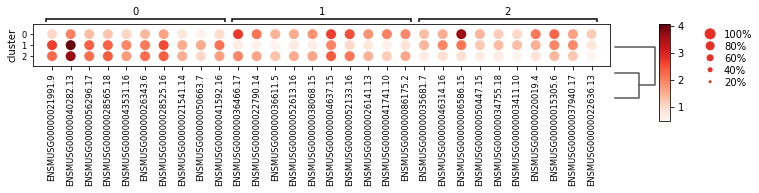

In [13]:
sc.pl.rank_genes_groups_dotplot(gene_adata)

## Plotting

In [14]:
name_df = pd.read_msgpack(result_dir / f'{mc_type}_marker_name.msg')
score_df = pd.read_msgpack(result_dir / f'{mc_type}_marker_test_score.msg')
fold_change_df = pd.read_msgpack(result_dir / f'{mc_type}_marker_fold_change.msg')